In [242]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
import torch.nn.functional as F
from ModelsLib import LSTM

In [243]:
training_set = pd.read_csv('train_ts_top5.csv', index_col='item_id')

In [244]:
training_set = training_set.T.values.reshape(-1, len(training_set))

In [245]:
train = training_set[:int(0.8 * len(training_set))]
valid = training_set[int(0.8 * len(training_set)):int(0.9 * len(training_set))]
test = training_set[int(0.9 * len(training_set)):]

In [246]:
test.shape

(195, 153)

In [247]:
def sliding_windows(data, seq_length, pred_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1-pred_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+pred_length+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc =  MinMaxScaler()
train = sc.fit_transform(train)
valid = sc.transform(valid)
test = sc.transform(test)

seq_length = 90
pred_length = 14

x_train, y_train = sliding_windows(train, seq_length, pred_length)
x_valid, y_valid = sliding_windows(valid, seq_length, pred_length)
x_test, y_test = sliding_windows(test, seq_length, pred_length)


trainX = Variable(torch.Tensor(np.array(x_train)))
trainy = Variable(torch.Tensor(np.array(y_train)))
validX = Variable(torch.Tensor(np.array(x_valid)))
validy = Variable(torch.Tensor(np.array(y_valid)))
testX = Variable(torch.Tensor(np.array(x_test)))
testy = Variable(torch.Tensor(np.array(y_test)))

In [248]:
input_size = 153
hidden_size = 153 * 15
num_layers = 1
num_classes = 14

best_model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
best_model.load_state_dict(torch.load('best_model_n_features.pt'))
best_model.eval()

LSTM(
  (lstm): LSTM(153, 2295, batch_first=True)
  (fc): Linear(in_features=2295, out_features=2142, bias=True)
)

In [249]:
preds = best_model(testX)

In [250]:
preds.shape, testy.shape

(torch.Size([90, 14, 153]), torch.Size([90, 14, 153]))

In [251]:
preds = preds.detach().numpy()
testy = testy.detach().numpy()

## Tests lstm vs naive

In [252]:
naive_base = testX[:, -1:, :].detach().numpy()

In [253]:
naive_pred = np.zeros((preds.shape))

for i in range(naive_pred.shape[0]):
    for j in range(naive_pred.shape[1]):
        for k in range(naive_pred.shape[2]):
            naive_pred[i, j, k] = naive_base[i, 0, k]

In [254]:
def MSE(x, y):
    return np.sqrt(np.mean((x - y) ** 2))

In [255]:
mse_days_naive = []
mse_days_lstm = []

for i in range(testy.shape[1]):
    mse_days_naive.append(MSE(testy[:, i, :], naive_pred[:, i, :]))
    mse_days_lstm.append(MSE(testy[:, i, :], preds[:, i, :]))

0.13267065271209813
0.14425346


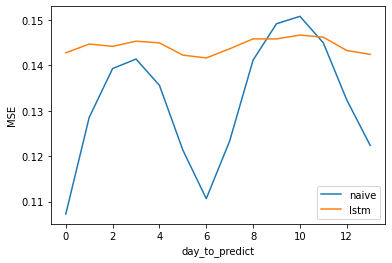

In [256]:
plt.plot(
    mse_days_naive,
    label='naive'
)

plt.plot(
    mse_days_lstm,
    label='lstm'
)

print(MSE(testy, naive_pred))
print(MSE(testy, preds))

plt.xlabel('day_to_predict')
plt.ylabel('MSE')
plt.legend()
plt.show()

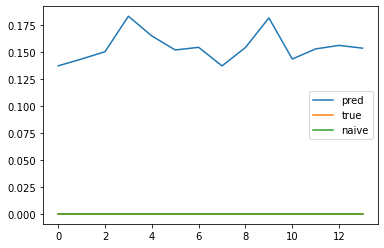

In [121]:
plt.plot(
    preds[50, :, 0],
    label='pred'
)

plt.plot(
    testy[50, :, 0],
    label='true'
)

plt.plot(
    naive_pred[50, :, 0],
    label='naive'
)

plt.legend()
plt.show()

In [37]:
testy

array([[[0.00042485, 0.00676041, 0.00131575, ..., 0.00165644,
         0.00100436, 0.00132036],
        [0.00046795, 0.01095187, 0.00106905, ..., 0.00118924,
         0.00090393, 0.00117365],
        [0.00049874, 0.00973499, 0.00205586, ..., 0.00227229,
         0.0014635 , 0.00146706],
        ...,
        [0.0005049 , 0.01230395, 0.00232998, ..., 0.00246342,
         0.00265438, 0.00244511],
        [0.00057879, 0.00892374, 0.00148022, ..., 0.00189004,
         0.00167872, 0.0022984 ],
        [0.00048643, 0.00797729, 0.00230257, ..., 0.00237847,
         0.00156393, 0.00102695]],

       [[0.00046795, 0.01095187, 0.00106905, ..., 0.00118924,
         0.00090393, 0.00117365],
        [0.00049874, 0.00973499, 0.00205586, ..., 0.00227229,
         0.0014635 , 0.00146706],
        [0.00060341, 0.0114927 , 0.00257668, ..., 0.00169891,
         0.00246786, 0.00298303],
        ...,
        [0.00057879, 0.00892374, 0.00148022, ..., 0.00189004,
         0.00167872, 0.0022984 ],
        [0.0